<a href="https://colab.research.google.com/github/tgstoecker/teaching/blob/master/AppliedBioinformatics/Notebooks/WGGC_diff_exp_edgeR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differential Expression Analysis

In [ ]:
R.Version()

$platform
[1] "x86_64-pc-linux-gnu"

$arch
[1] "x86_64"

$os
[1] "linux-gnu"

$system
[1] "x86_64, linux-gnu"

$status
[1] ""

$major
[1] "4"

$minor
[1] "1.1"

$year
[1] "2021"

$month
[1] "08"

$day
[1] "10"

$`svn rev`
[1] "80725"

$language
[1] "R"

$version.string
[1] "R version 4.1.1 (2021-08-10)"

$nickname
[1] "Kick Things"

##Installation of necessary R packages

In [ ]:
install.packages("reshape2", verbose = TRUE)
install.packages("RColorBrewer", verbose = TRUE)
install.packages("ggplot2", verbose = TRUE)
install.packages("statmod", verbose = TRUE)
install.packages("gplots", verbose = TRUE)
install.packages("BiocManager", verbose = TRUE)
BiocManager::install(ask = FALSE)
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install("limma")
BiocManager::install("edgeR")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

system (cmd0): /usr/lib/R/bin/R CMD INSTALL

foundpkgs: reshape2, /tmp/RtmpZB7QcA/downloaded_packages/reshape2_1.4.4.tar.gz

files: /tmp/RtmpZB7QcA/downloaded_packages/reshape2_1.4.4.tar.gz

1): succeeded '/usr/lib/R/bin/R CMD INSTALL -l '/usr/local/lib/R/site-library' '/tmp/RtmpZB7QcA/downloaded_packages/reshape2_1.4.4.tar.gz''

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

system (cmd0): /usr/lib/R/bin/R CMD INSTALL

foundpkgs: RColorBrewer, /tmp/RtmpZB7QcA/downloaded_packages/RColorBrewer_1.1-2.tar.gz

files: /tmp/RtmpZB7QcA/downloaded_packages/RColorBrewer_1.1-2.tar.gz

1): succeeded '/usr/lib/R/bin/R CMD INSTALL -l '/usr/local/lib/R/site-library' '/tmp/RtmpZB7QcA/downloaded_packages/RColorBrewer_1.1-2.tar.gz''

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

system (cmd0): /usr/lib/R/bin/R CMD INSTALL

foundpkgs: ggplot2, /tmp/R

In [ ]:
library(reshape2)
library(limma)
library(edgeR)
library(ggplot2)
library(RColorBrewer)
library(gplots)
library(statmod)

## Count data table

Exchanging this raw data link for another appropiate input table allows you to perform the analysis with that particular data. 

In [ ]:
counts <- "https://raw.githubusercontent.com/tgstoecker/teaching/master/AppliedBioinformatics/B73/gene-level/total_file.count"
fc_res <- read.table(counts, header = T, row.names = 1)

Check the names of your columns and take a look at your table:


In [ ]:
colnames(fc_res)
head(fc_res)

[1] "Chr"                              "Start"                           
 [3] "End"                              "Strand"                          
 [5] "Length"                           "B73_con_1_trimmed_sorted.bam"    
 [7] "B73_con_2_trimmed_sorted.bam"     "B73_con_3_trimmed_sorted.bam"    
 [9] "B73_con_4_trimmed_sorted.bam"     "B73_drought_1_trimmed_sorted.bam"
[11] "B73_drought_2_trimmed_sorted.bam" "B73_drought_3_trimmed_sorted.bam"
[13] "B73_drought_4_trimmed_sorted.bam"

,Chr,Start,End,Strand,Length,B73_con_1_trimmed_sorted.bam,B73_con_2_trimmed_sorted.bam,B73_con_3_trimmed_sorted.bam,B73_con_4_trimmed_sorted.bam,B73_drought_1_trimmed_sorted.bam,B73_drought_2_trimmed_sorted.bam,B73_drought_3_trimmed_sorted.bam,B73_drought_4_trimmed_sorted.bam
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
GRMZM2G059865,1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1,4854;4857;4857;5342;5342;5342;5857;6108;6108;6108;6362;6362;6639;6639;6918;6918;7594;7594;9193;9193,5188;5188;5188;5975;5975;5407;5975;6265;6355;6265;6517;6517;6797;6797;7120;7120;7903;7903;9652;9652,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-,2505,427,1351,1840,1612,724,1030,1196,1177
GRMZM5G888250,1,9882,10387,-,506,1,7,0,5,1,1,4,3
GRMZM2G093344,1;1;1;1,109519;109759;110769;111466,109675;109935;111142;111769,-;-;-;-,1012,26,61,102,93,57,85,91,92
GRMZM2G093399,1;1;1;1,136307;136719;137205;138552,136634;137013;137290;138929,+;+;+;+,1087,0,0,0,0,0,0,0,0
GRMZM5G809743,1,144361,144657,+,297,45,46,134,178,68,105,89,113
GRMZM5G833153,1,144957,145646,+,690,40,67,133,136,55,76,106,118


Shorten the column names indicating the samples - e.g.:


In [ ]:
colnames(fc_res) <- sub("_trimmed_sorted.bam", "", colnames(fc_res))
colnames(fc_res)

[1] "Chr"           "Start"         "End"           "Strand"       
 [5] "Length"        "B73_con_1"     "B73_con_2"     "B73_con_3"    
 [9] "B73_con_4"     "B73_drought_1" "B73_drought_2" "B73_drought_3"
[13] "B73_drought_4"

## Data exploration and quality

For data exploration and visualization, it is useful to work with transformed versions of count data.  
This is because the distribution of count values is usually extremely skewed.
Log2transformation helps to approximately normalize the distribution.
Take a look at your samples and create a histogram - e.g.:

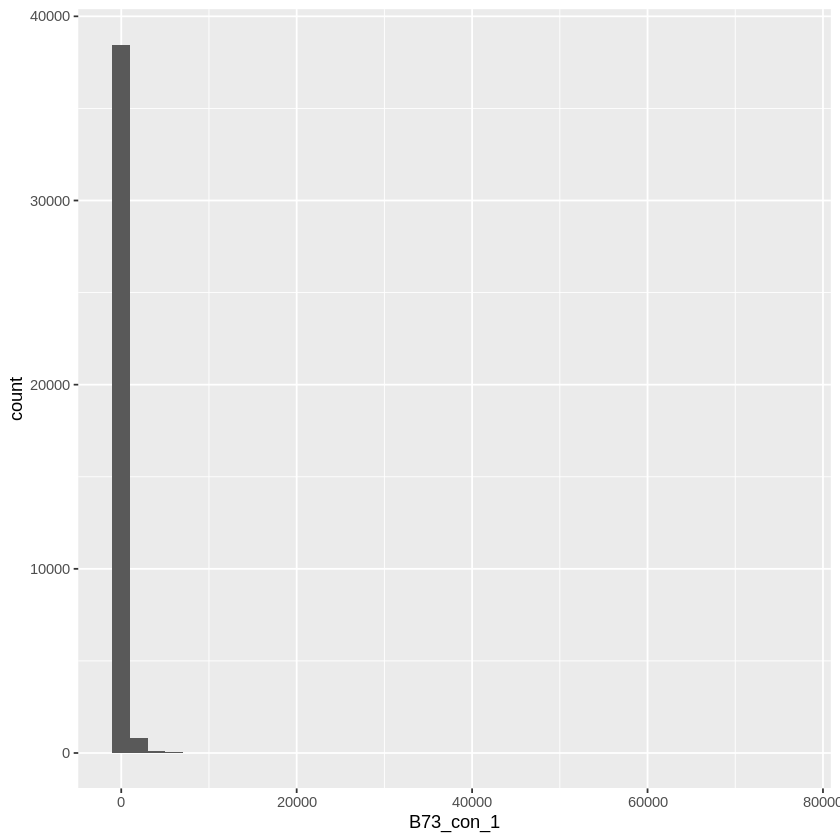

In [ ]:
ggplot(fc_res, aes(x = B73_con_1)) + 
  geom_histogram(binwidth = 2000)

Log base 2 is typically used here as it allows for the conversion back to the original scale:  
A difference of 1 on the log base2  scale  corresponds  to  a  fold  change  of  2  on  the  original count scale.  
Since  count  values  for  a  gene  can  be  zero  in some conditions, this results in non-finite values which would be excluded in the plots.  
An easy way around this is the use of pseudocounts, e.g.  transforming the data by adding e.g. a 1 count everywhere 

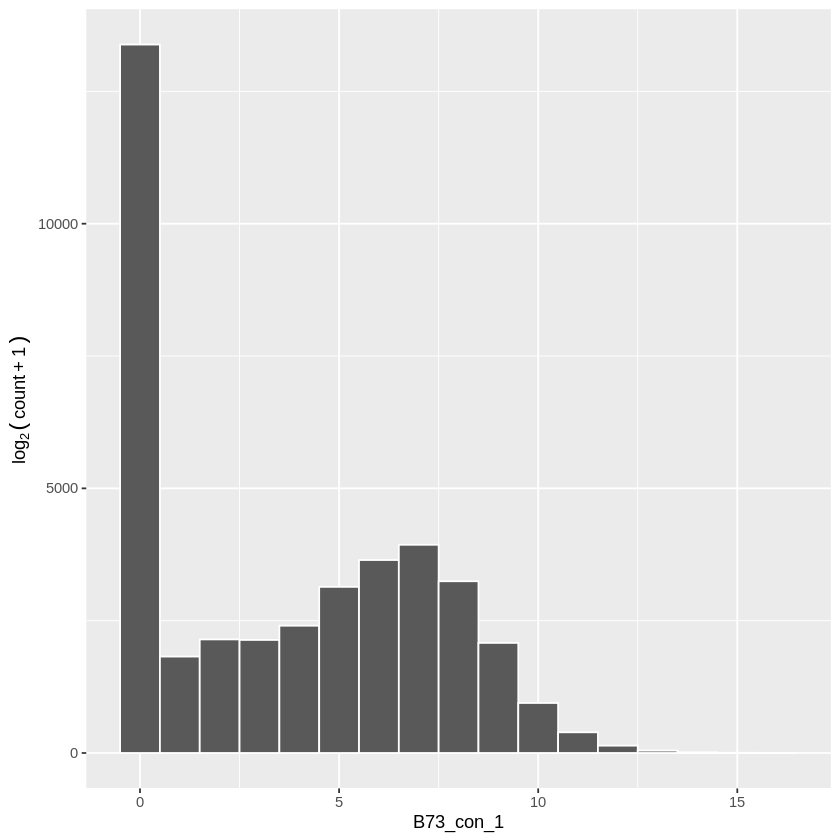

In [ ]:
pseudoCount = log2(fc_res[, 6:13] + 1)

ggplot(pseudoCount, aes(x = B73_con_1)) + 
  ylab(expression(log[2](count + 1))) +
  geom_histogram(colour = "white", binwidth = 1)

Taking a look at the count distribution between samples/replicates counts is useful to assess effects even before filtering and normalization:
This can for instance be done with Boxplots
In the following we visualize the distribution of the pseoudocounts in all of your samples.

Quick recap on boxplots:
Boxes are formed with sides at the 25-th and 75-th percentiles of the distribution.  
The line within a box represents the median. 

No id variables; using all as measure variables



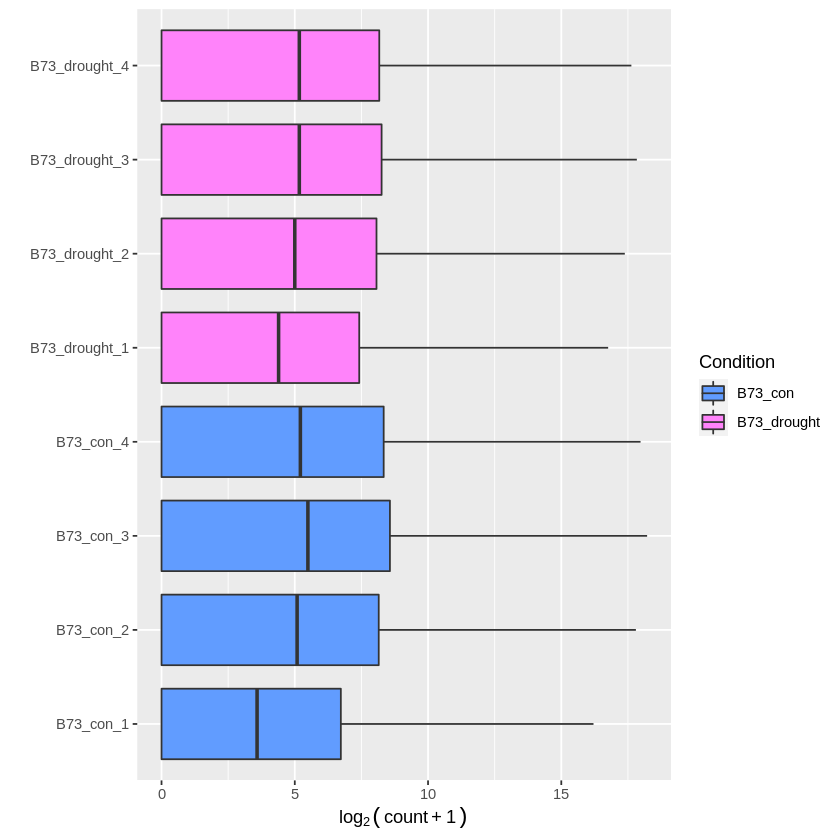

In [ ]:
#ignore message about IDs
df = melt(pseudoCount)
df = data.frame(df, Condition = substr(df$variable,1,nchar(as.character(df$variable))-2))

ggplot(df, aes(x = variable, y = value, fill = Condition)) + 
  geom_boxplot() + xlab("") +
  ylab(expression(log[2](count + 1))) + 
  scale_fill_manual(values = c("#619CFF", "orchid1")) +
  coord_flip()

Pseudocounts distributions can also be summarized by means of a density plot.

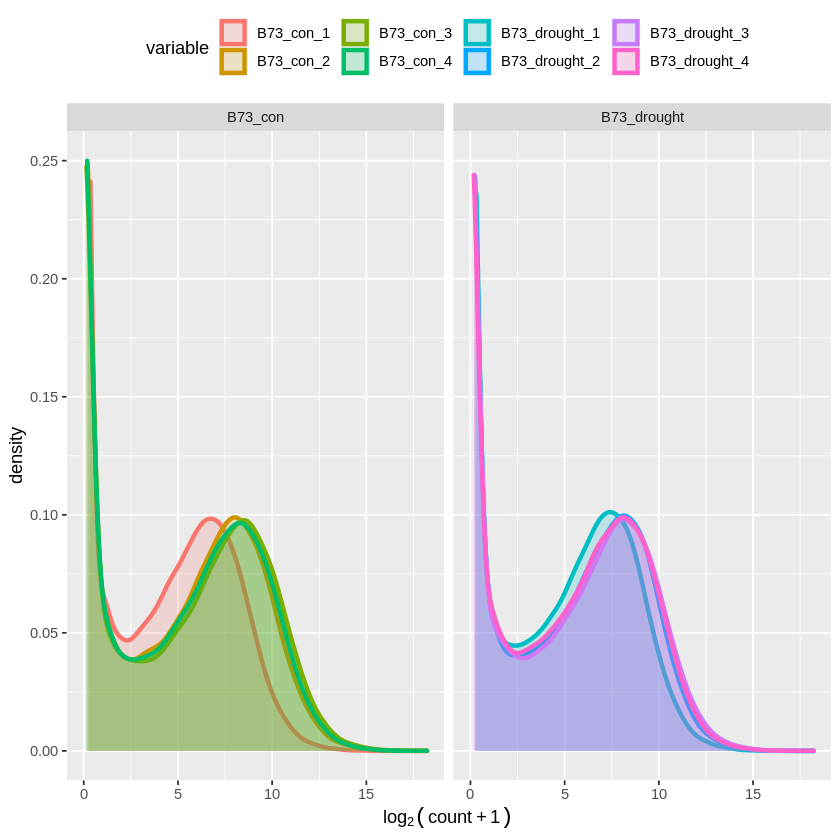

In [ ]:
ggplot(df, aes(x = value, colour = variable, fill = variable)) + 
  ylim(c(0, 0.25)) +
  geom_density(alpha = 0.2, size = 1.25) + 
  facet_wrap(~ Condition) +
  theme(legend.position = "top") + 
  xlab(expression(log[2](count + 1)))

Create a vector indicating treatment conditions of the samples 
- logic: columns left to right

In [ ]:
group = c("control", "control", "control", "control", "drought", "drought", "drought", "drought")
group

[1] "control" "control" "control" "control" "drought" "drought" "drought"
[8] "drought"

In [ ]:
# create a DGE list object - the core of using edgeR
# For our purposes the DGEList-object should contain matrixes/dataframes of raw counts, group/treatment info as well as gene names 
##ignore error warning - Warning message in seq_len(head.end.idx): ...
?DGEList
dge = DGEList(counts = fc_res[, 6:13], group = group, genes = rownames(fc_res))

Warning message in seq_len(head.end.idx):
“first element used of 'length.out' argument”
ERROR while rich displaying an object: Error in seq_len(head.end.idx): argument must be coercible to non-negative integer

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_conte

In [ ]:
ls.str()

A :  num [1:39475] 9.57 2 5.35 0 5.54 ...
check : Formal class 'TopTags' [package "edgeR"] with 1 slot
col :  chr [1:8] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" ...
counts :  chr "https://raw.githubusercontent.com/tgstoecker/teaching/master/AppliedBioinformatics/B73/gene-level/total_file.count"
cpm :  num [1:39475, 1:8] 73.497 0.172 4.475 0 7.746 ...
CvsD :  num [1:2, 1] -1 1
den : List of 7
 $ x        : num [1:512] -3.12 -3.09 -3.05 -3.02 -2.99 ...
 $ y        : num [1:512] 7.86e-07 1.15e-06 1.65e-06 2.36e-06 3.33e-06 ...
 $ bw       : num 0.262
 $ n        : int 22996
 $ call     : language density.default(x = lcpm_filtered[, i])
 $ data.name: chr "lcpm_filtered[, i]"
 $ has.na   : logi FALSE
design :  num [1:8, 1:2] 1 1 1 1 0 0 0 0 0 0 ...
desired_subset : Formal class 'TopTags' [package "edgeR"] with 1 slot
desired_subset_B73 : 'data.frame':	22996 obs. of  3 variables:
 $ gene_id         : chr  "GRMZM2G009282" "GRMZM2G064091" "GRMZM2G132547" "AC186231.4_FG002" .

### MA-plots

A plot of log-fold change (M-values) vs the log average (A-values)  
M-values = log of the ratio of level counts for each gene between two samples  
A-values = the average level counts for each gene across the two samples (higher ~ more trustworthy) 

MA-plots are a useful way of visualizing the "reproducibility" between replicates/samples of an experiment.  
In other words a MA-plot usually indicates that normalization is needed/ would be appropriate.  
In a MA plot, genes with similar expression levels in two samples will appear around the horizontal line (y= 0).  
The code also plots a loess fit (in red) - basically a trend in the bias related to the mean expression.  

`geom_smooth()` using formula 'y ~ x'



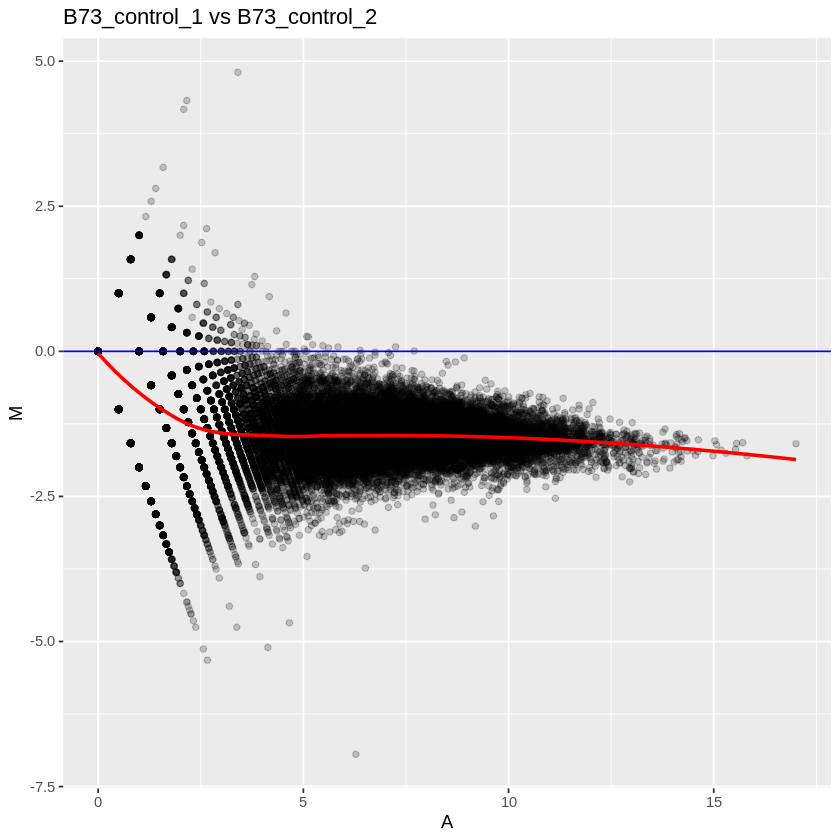

In [ ]:
x = pseudoCount$B73_con_1
y = pseudoCount$B73_con_2

## compute M-values
M = x - y

## compute A-values
A = (x + y)/2

df = data.frame(A, M)

p <- ggplot(df, aes(x = A, y = M)) + 
  geom_point(size = 1.5, alpha = 1/5) +
  geom_hline(color = "blue2", yintercept = 0) + 
  stat_smooth(se = FALSE, method = "loess", color = "red") 
p +  ggtitle("B73_control_1 vs B73_control_2")

## Filtering our data 


###Transformation of raw read counts

In [ ]:
cpm <- cpm(dge)
lcpm <- cpm(dge, log=TRUE)

# checkout the library sizes of your samples
dge$samples

head(dge)
summary(cpm)

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
B73_con_1,control,5809745,1
B73_con_2,control,16800214,1
B73_con_3,control,22197074,1
B73_con_4,control,18492899,1
B73_drought_1,drought,8999241,1
B73_drought_2,drought,13853620,1
B73_drought_3,drought,17348318,1
B73_drought_4,drought,15747578,1


An object of class "DGEList"
$counts
              B73_con_1 B73_con_2 B73_con_3 B73_con_4 B73_drought_1
GRMZM2G059865       427      1351      1840      1612           724
GRMZM5G888250         1         7         0         5             1
GRMZM2G093344        26        61       102        93            57
GRMZM2G093399         0         0         0         0             0
GRMZM5G809743        45        46       134       178            68
GRMZM5G833153        40        67       133       136            55
              B73_drought_2 B73_drought_3 B73_drought_4
GRMZM2G059865          1030          1196          1177
GRMZM5G888250             1             4             3
GRMZM2G093344            85            91            92
GRMZM2G093399             0             0             0
GRMZM5G809743           105            89           113
GRMZM5G833153            76           106           118

$samples
                group lib.size norm.factors
B73_con_1     control  5809745            1
B73_con_2     control 16800214            1
B73_con_3     control 22197074            1
B73_con_4     control 18492899            1
B73_drought_1 drought  8999241            1
B73_drought_2 drought 13853620            1
B73_drought_3 drought 17348318            1
B73_drought_4 drought 15747578            1

$genes
                      genes
GRMZM2G059865 GRMZM2G059865
GRMZM5G888250 GRMZM5G888250
GRMZM2G093344 GRMZM2G093344
GRMZM2G093399 GRMZM2G093399
GRMZM5G809743 GRMZM5G809743
GRMZM5G833153 GRMZM5G833153

   B73_con_1           B73_con_2           B73_con_3        
 Min.   :    0.000   Min.   :    0.000   Min.   :    0.000  
 1st Qu.:    0.000   1st Qu.:    0.000   1st Qu.:    0.000  
 Median :    1.893   Median :    1.964   Median :    1.982  
 Mean   :   25.332   Mean   :   25.332   Mean   :   25.332  
 3rd Qu.:   18.073   3rd Qu.:   16.845   3rd Qu.:   17.074  
 Max.   :13030.692   Max.   :13577.208   Max.   :13758.931  
   B73_con_4         B73_drought_1       B73_drought_2      
 Min.   :    0.000   Min.   :    0.000   Min.   :    0.000  
 1st Qu.:    0.000   1st Qu.:    0.000   1st Qu.:    0.000  
 Median :    1.947   Median :    2.222   Median :    2.238  
 Mean   :   25.332   Mean   :   25.332   Mean   :   25.332  
 3rd Qu.:   17.412   3rd Qu.:   18.890   3rd Qu.:   19.273  
 Max.   :13920.857   Max.   :12316.816   Max.   :12344.716  
 B73_drought_3       B73_drought_4      
 Min.   :    0.000   Min.   :    0.000  
 1st Qu.:    0.000   1st Qu.:    0.000  
 Median :    2.017   Me

**B73 based example**  
A CPM value of 1 for a gene is equal to having 5.8 counts in the sample with the lowest sequencing depth (B73_con_1, lib.size ~ 5.8 million) or 22 counts in the sample with the greatest sequencing depth (B73_con_3, lib.size ~ 22 million).

Log-CPM values are generally very suited for exploratory plots. 
When you set log=TRUE, the edgeR's cpm *function* adds an offset to the CPM values before conversion to the log2-scale. 
With default options, this offset is 2/L where 2 is the “prior count” (or offset) and L is the average lib.size in millions, so in other words: the log-CPM values are related to the CPM values by log2(CPM + 2/L). 

Why?
With this calculation we can enssure that any two read-counts with identical CPM values will also have identical log-CPM values. 
 1. Using such a "prior count" we never compute the logarithm of 0
 2. This also reduces (here it gets nerdy) the variability of all genes with very low counts by shrinking all the inter-sample log-fold-changes towards 0, which has been shown to be nice for exploratory plotting. 

Now, imagine a dataset, which average library size is about 50 million, so L approx. 50 and the minimum log-CPM value for each sample becomes log2(2/50) = -4.644. 
In other words, a count of zero for this data maps to a log-CPM value of -4.644 after adding the "prior count".

Now check your data/samples:

In [ ]:
L <- mean(dge$samples$lib.size) * 1e-6
M <- median(dge$samples$lib.size) * 1e-6
c(L, M)
summary(lcpm)

[1] 14.90609 16.27390

   B73_con_1        B73_con_2        B73_con_3        B73_con_4     
 Min.   :-2.898   Min.   :-2.898   Min.   :-2.898   Min.   :-2.898  
 1st Qu.:-2.898   1st Qu.:-2.898   1st Qu.:-2.898   1st Qu.:-2.898  
 Median : 1.020   Median : 1.069   Median : 1.082   Median : 1.057  
 Mean   : 1.068   Mean   : 1.064   Mean   : 1.077   Mean   : 1.085  
 3rd Qu.: 4.186   3rd Qu.: 4.086   3rd Qu.: 4.105   3rd Qu.: 4.133  
 Max.   :13.670   Max.   :13.729   Max.   :13.748   Max.   :13.765  
 B73_drought_1    B73_drought_2    B73_drought_3    B73_drought_4   
 Min.   :-2.898   Min.   :-2.898   Min.   :-2.898   Min.   :-2.898  
 1st Qu.:-2.898   1st Qu.:-2.898   1st Qu.:-2.898   1st Qu.:-2.898  
 Median : 1.237   Median : 1.246   Median : 1.105   Median : 1.237  
 Mean   : 1.153   Mean   : 1.161   Mean   : 1.102   Mean   : 1.178  
 3rd Qu.: 4.250   3rd Qu.: 4.279   3rd Qu.: 4.147   3rd Qu.: 4.198  
 Max.   :13.588   Max.   :13.592   Max.   :13.718   Max.   :13.653  

Removing genes that are lowly expressed
RNA-Seq datasets will include a mix of genes, some of them expressed and some which are not. 
For our purposes it is of interest to examine genes that are expressed in one treatment but not in the other. 
However some genes could be UNexpressed throughout all samples! 

Are there any genes in your 8 samples that fit this scenario?

In [ ]:
head(dge$counts)
table(rowSums(dge$counts==0)==8)

,B73_con_1,B73_con_2,B73_con_3,B73_con_4,B73_drought_1,B73_drought_2,B73_drought_3,B73_drought_4
GRMZM2G059865,427,1351,1840,1612,724,1030,1196,1177
GRMZM5G888250,1,7,0,5,1,1,4,3
GRMZM2G093344,26,61,102,93,57,85,91,92
GRMZM2G093399,0,0,0,0,0,0,0,0
GRMZM5G809743,45,46,134,178,68,105,89,113
GRMZM5G833153,40,67,133,136,55,76,106,118



FALSE  TRUE 
31410  8065 

Why do we care?
Genes that do not have a worthwhile number of reads in any sample should be filtered out of the downstream analyses. 
Biological reason: Genes not expressed at a biologically relevant level in any of our samples/conditions are uninteresting 
Statistical reason: removal of low count genes reduces statistical "noise"; more precisely:
estimation of the mean-variance relationship is made more precise and also the number of statistical tests which need to be performed in the subsequent steps for differential expression are reduced. 

EdgeR has an automatic way to filter our genes, while trying to keep as many as possible which are deemed worthwhile, regarding their counts 
(it is of course possible to dive deeper and set custom cutoffs etc.).
-> for our purposes and most use cases the automatic way is a reasonable choice

Now, how does edgeR go about the filtering?
The basic idea is to keep all genes which possess a minimum number of counts in a reasonable number of our samples.
CPM values instead of raw counts are used as to not give preference to samples with large library sizes as discussed above. 
E.g. large lib.size leads to lower CPM cutoff;
-> larger library sizes (higher resolution) allow for the exploration of more genes at lower expression levels 
(Usually the function keeps genes with about 10 or more read counts in enough samples) the cutoff can thus be roughly approximated by: log2(10/M + 2/L)

To sum up: Determining factors are the library sizes of the samples, the minimum required count and the design of the experiment.

For more details see documentation:

In [ ]:
?filterByExpr
##ignore error warning - Warning message in seq_len(head.end.idx):

Warning message in seq_len(head.end.idx):
“first element used of 'length.out' argument”
ERROR while rich displaying an object: Error in seq_len(head.end.idx): argument must be coercible to non-negative integer

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_conte

All this already indicates that such filtering is very much experiment specific.
But how do we get edgeR/R to understand our data or research question?

This leads us to another necessary step:


##Creating a design matrix 

With the data in the course we want to find out which genes are differentially expressed between control and drought treatment. 
A design matrix of our data is easily created using the sample information.
note1: in this simple scenario we only need to make use of the group vector, created at the very beginning of this workflow 
note2: with ~0 we remove the intercept from our 2 level factor, which we treat as two seperate groups; we don't have any interaction in this simple model

In [ ]:
design <- model.matrix(~0+group)
design

,groupcontrol,groupdrought
1,1,0
2,1,0
3,1,0
4,1,0
5,0,1
6,0,1
7,0,1
8,0,1


Design matrices can be much more complex, which (theoretically) allows you to model every well designed experiment e.g. factorial designs, complex interactions and much, much more are possible

Check the column names - these should be your groups of interest?

In [ ]:
colnames(design)

[1] "groupcontrol" "groupdrought"

Now we combine everything previously mentioned and perform edgeR's automatic filtering.
Note how well designed edgeR is -
Filtering the DGEList-object this way keeps gene and count info for the retained genes correctly associated.

In [ ]:
keep <- filterByExpr(dge, design)
dge_filtered <- dge[keep, , keep.lib.sizes=FALSE]
#the amount of genes after filtering is reduced - how much in your case?
dim(dge_filtered)

[1] 22996     8

All rows without any counts should definitely have been excluded:


In [ ]:
table(rowSums(dge_filtered$counts==0)==8)


FALSE 
22996 

Data exploration also means visualization, so after so much theory let's plot the density distribution before and after filtering.
To brush up your R skills: Take your time, go through the code line by line and try to understand what everything does.

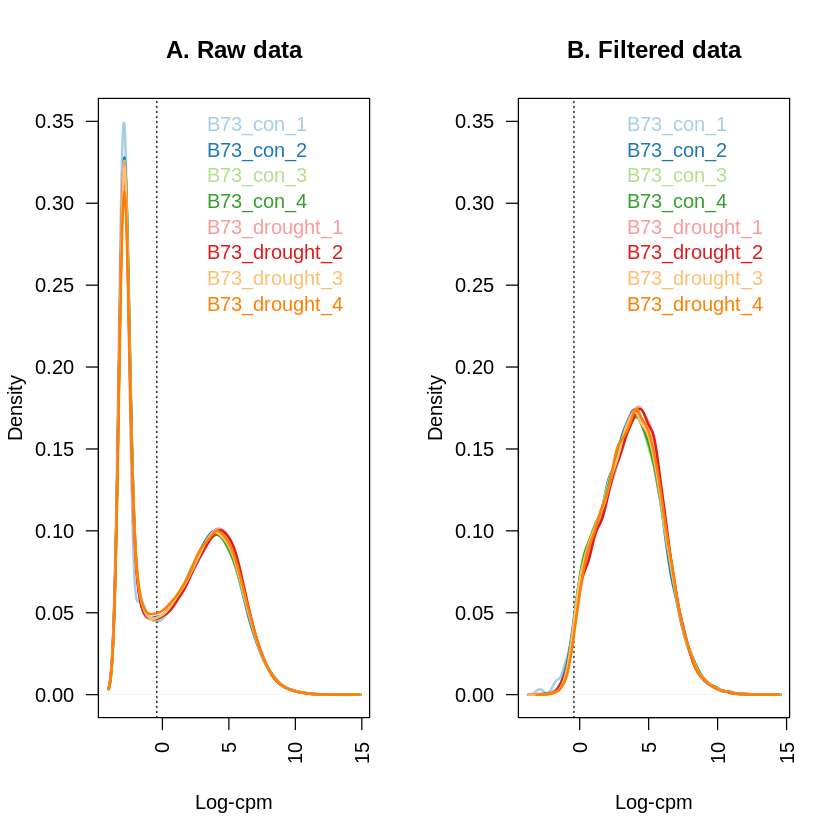

In [ ]:
#general setup of the plots
par(mfrow=c(1,2))

lcpm.cutoff <- log2(10/M + 2/L)

# create first plot
lcpm_unfiltered <- cpm(dge, log=TRUE)
nsamples <- ncol(dge)
col <- brewer.pal(nsamples, "Paired")
plot(density(lcpm_unfiltered[,1]), col=col[1], lwd=2, ylim=c(0,0.35), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm_unfiltered[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", row.names(dge$samples), text.col=col, bty="n")

# create second plot
lcpm_filtered <- cpm(dge_filtered, log=TRUE)
plot(density(lcpm_filtered[,1]), col=col[1], lwd=2, ylim=c(0,0.35), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm_filtered[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", row.names(dge_filtered$samples), text.col=col, bty="n")

You just plotted the density of log-CPM values of all samples before and after filtering!
The vertical line in each plot marks the aforementioned, approximated log-CPM threshold used in the filtering step.

Based on the inspection and visualization of our data we can conclude that a good amount of genes within each sample are either un-/verylow-expressed as is indicated by the small and negative logCPM values.

##Normalization (of gene expression distributions)

With Normalization systemic differences between samples are removed in order to negate the impact of technical bias (in other words: external factors that are not of biological interest) on the final results as much as possible.  
Normalization generally entails that an appropriate baseline is determined; sample counts are then expressed relative to this baseline. 

For robust diff. exp. analysis we want to assume that all samples have a similar range and distribution of expression values. 
We can make use of various normalization approaches to equalise the expression distributions so that all our samples are similar in this aspect across the entire experiment.

Any plot showing the per sample expression distributions, such as a density or boxplot, is useful in determining whether any samples are considerably different to others. 
Throughout all samples of our data distributions of log-CPM values are already quite similar (as can be seen e.g. in the created density plots)

Nevertheless, we are going to perform normalization by the method of trimmed mean of M-values (TMM) -

With edgeR this can be performed using the calcNormFactors function:

In [ ]:
dge_normalized <- calcNormFactors(dge_filtered, method = "TMM")
#have a look at the individual normalization factors of the samples we just created
dge_normalized$samples$norm.factors
head(dge_normalized)

[1] 1.0047701 0.9547762 0.9916744 1.0029981 1.0059957 1.0034099 1.0043727
[8] 1.0336966

An object of class "DGEList"
$counts
                 B73_con_1 B73_con_2 B73_con_3 B73_con_4 B73_drought_1
GRMZM2G059865          427      1351      1840      1612           724
GRMZM2G093344           26        61       102        93            57
GRMZM5G809743           45        46       134       178            68
GRMZM5G833153           40        67       133       136            55
AC177838.2_FG015         5        10        25        26             5
GRMZM2G471814            5        28        25        15             6
                 B73_drought_2 B73_drought_3 B73_drought_4
GRMZM2G059865             1030          1196          1177
GRMZM2G093344               85            91            92
GRMZM5G809743              105            89           113
GRMZM5G833153               76           106           118
AC177838.2_FG015            20            36            28
GRMZM2G471814               13            14            12

$samples
                group lib.size norm.factors
B73_con_1     control  5803745    1.0047701
B73_con_2     control 16782426    0.9547762
B73_con_3     control 22173682    0.9916744
B73_con_4     control 18473211    1.0029981
B73_drought_1 drought  8987538    1.0059957
B73_drought_2 drought 13833901    1.0034099
B73_drought_3 drought 17328736    1.0043727
B73_drought_4 drought 15719626    1.0336966

$genes
                            genes
GRMZM2G059865       GRMZM2G059865
GRMZM2G093344       GRMZM2G093344
GRMZM5G809743       GRMZM5G809743
GRMZM5G833153       GRMZM5G833153
AC177838.2_FG015 AC177838.2_FG015
GRMZM2G471814       GRMZM2G471814

These serve as "scaling factors" for the individual library sizes.
For the data used in the course the effect of TMM-normalisation is rather mild, as can be seen with the norm.factors, which are all relatively close to 1.

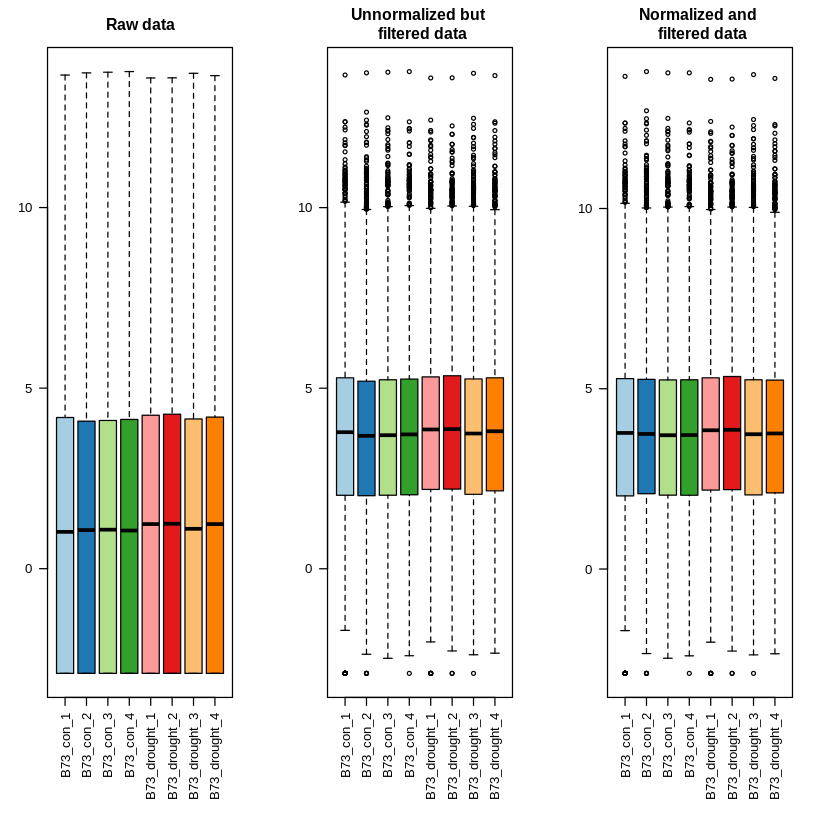

In [ ]:
#Let's plot a comparison of the raw, filtered and normalized sample log-CPM values using boxplots - a.k.a. expression distribution
#general setup of the plots
par(mfrow=c(1,3), mar = c(9, 3, 3, 3))

#first plot - raw
lcpm <- cpm(dge, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Raw data",ylab="Log-cpm")

# second plot - un-normalized but filtered
lcpm_filtered <- cpm(dge_filtered, log=TRUE)
boxplot(lcpm_filtered, las=2, col=col, main="")
title(main="Unnormalized but \n filtered data",ylab="Log-cpm")

# second plot - normalized and filtered
lcpm_normalized <- cpm(dge_normalized, log=TRUE)
boxplot(lcpm_normalized, las=2, col=col, main="")
title(main="Normalized and \n filtered data",ylab="Log-cpm")

As you can see there is not much to see ;)  
Thus in order to give a better visual representation of the effects of normalisation, we are going to manually worsen our data a bit.
In the code provided below, counts of the 7th sample are reduced to 5% of their original values, and in the 8th sample they are multiplied to be 5-times larger.
Please feel free to make it even worse!

[1] 1.34380629 1.25688250 1.34908482 1.35669571 1.36137962 1.36578357 0.02600296
[8] 6.69056809

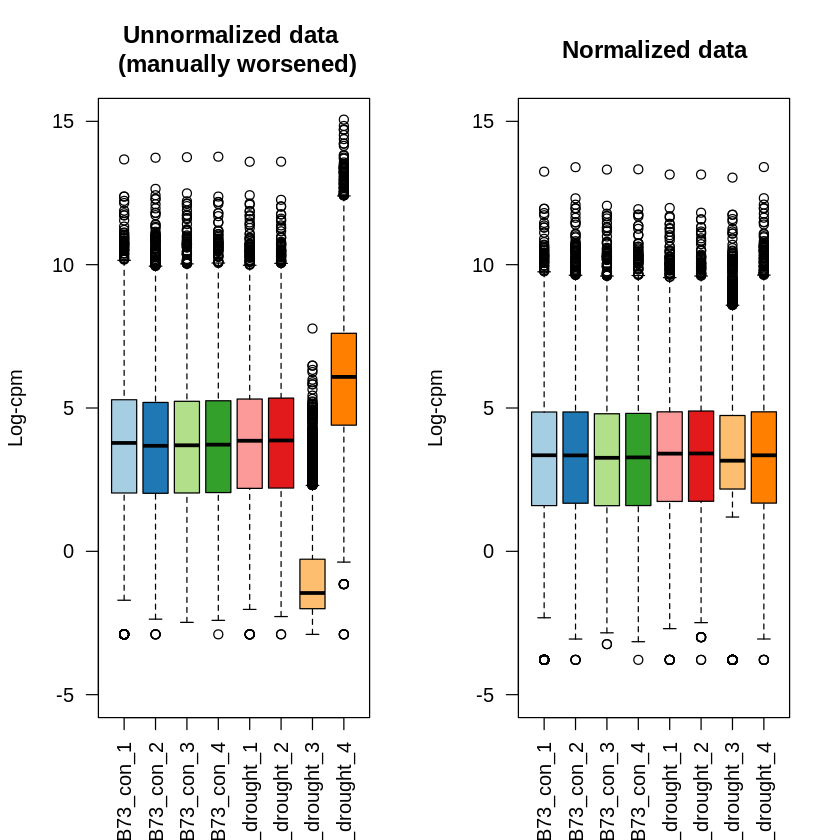

In [ ]:
#Let's repeat the plot (without raw/unfltered data) - but with worsely distributed data - this time concentrating on normalization
dge_filtered_worse <- dge_filtered
dge_filtered_worse$samples$norm.factors <- 1
dge_filtered_worse$counts[,7] <- ceiling(dge_filtered_worse$counts[,1]*0.05)
dge_filtered_worse$counts[,8] <- dge_filtered_worse$counts[,2]*5

#general setup of the plots
par(mfrow=c(1,2))

# first plot - un-normalized and worsened
lcpm_filtered_worse <- cpm(dge_filtered_worse, log=TRUE)
boxplot(lcpm_filtered_worse, las=2, col=col, main="", ylim = c(-5, 15))
title(main="Unnormalized data \n (manually worsened)",ylab="Log-cpm")

#again perform normalization - and take a look at the norm.factors here, especially of all samples you altered!
dge_filtered_worse_normalized <- calcNormFactors(dge_filtered_worse)  
dge_filtered_worse_normalized$samples$norm.factors

# second plot - normalized
lcpm_filtered_worse_normalized <- cpm(dge_filtered_worse_normalized, log=TRUE)
boxplot(lcpm_filtered_worse_normalized, las=2, col=col, main="", ylim = c(-5, 15))
title(main="Normalized data",ylab="Log-cpm")

With the modified data the distributions are decidedly different between before compared to after normalization.  
Take special note of the TMM scaling factors of the altered samples – neither of the values should be close to 1.

##Dispersion estimation

EdgeR uses the negative binomial (NB) distribution to model the read counts for each gene in each sample. 
The dispersion parameter of the NB distribution accounts for variability between biological replicates - in fact three different kind of dispersions are estimated by edgeR.

In [ ]:
#All 3 dispersion estimates can easily be obtained from the estimateDisp function in one command:
dge_disp <- estimateDisp(dge_normalized, design, robust=TRUE)

#By this, to the DGEList object additional components (common.dispersion, etc.) are added, which contain the estimated dispersions. 
#The robust=TRUE option is generally recommended as it protects the empirical Bayes estimates against the impact of extreme/outlier genes with 
#overproportional large or small individual dispersions.

#Once negative binomial models are fitted and dispersion estimates are obtained, we could start with the differential expression analysis.
#A second layer or extension of methods can be further employed to consider gene-specific variability from both biological/technical sources.
#This is especially reasonable in multifactor experiments and/or when having more than two groups.
#-> quasi-likelihood (QL) methods 

#The estimation of QL dispersions is performed using the glmQLFit function:
fit <- glmQLFit(dge_disp, design, robust=TRUE)
#This returns a DGEGLM object (Digital Gene Expression Generalized Linear Model) containing the estimated values of the GLM coefficients for each individual gene. 

## We have made it, next up --> testing for differential expression

The next step is to test for differential expression between the experimental groups - in our case control vs drought treatment.  
For this, first the "contrast" has to be created, which corresponds to the comparison we are interested in.  

In [ ]:
# For this we can make use of limma's convenient makeContrasts function:
CvsD <- makeContrasts(groupdrought-groupcontrol, levels=design)

#In subsequent results, a positive log2-fold-change (logFC) will indicate a gene up-regulated in drought compared to control treated plants, 
#whereas a negative logFC will indicate a gene more highly expressed in control treated plants.

#EdgeR offers two main kinds of tests - QL F-tests and likelihood ratio tests (LRT).
#We will use the former as they perform stricter error control by accounting for the uncertainty in dispersion estimation:
res <- glmQLFTest(fit, contrast=CvsD)

*noteworthy:*  
Generally speaking, the QL F-test should be used as it far more robust and reliable.  
This becomes most apparent when the number of replicates is small.  

*in even more detail:*  
LRT is typically used for situations in which a dispersion parameter is not used, e.g., logistic regressions or Poisson models.  
However, for negative binomial models, the dispersion parameter needs to be estimated from the same data used to fit the model.  
This introduces extra uncertainty into the model fit that is not handled by LRT.  

In [ ]:
#Returning to the differential expression analysis
#The top diff. exp. genes can be viewed with function topTags:
topTags(res)

,genes,logFC,logCPM,F,PValue,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GRMZM2G009282,GRMZM2G009282,1.214854,5.791065,308.9851,2.649623e-09,6.093072e-05
GRMZM2G064091,GRMZM2G064091,1.738208,3.638968,210.2184,1.968581e-08,2.055652e-04
GRMZM2G132547,GRMZM2G132547,-1.426913,6.277188,197.9932,2.681751e-08,2.055652e-04
AC186231.4_FG002,AC186231.4_FG002,2.056854,3.521778,174.1850,5.178536e-08,2.977140e-04
GRMZM2G103647,GRMZM2G103647,-1.542851,5.632832,163.5297,7.150050e-08,2.995648e-04
GRMZM2G313184,GRMZM2G313184,-3.265420,1.520485,160.6981,7.816093e-08,2.995648e-04
GRMZM2G002704,GRMZM2G002704,2.878226,3.124161,142.8303,1.557779e-07,4.284876e-04
GRMZM2G117956,GRMZM2G117956,-1.991566,4.129187,139.5705,1.598281e-07,4.284876e-04
GRMZM2G053720,GRMZM2G053720,-1.986537,6.068600,166.6445,1.676982e-07,4.284876e-04


In order to control the **false discovery rate (FDR)**, multiple testing correction is performed using the Benjamini-Hochberg method.  
Each locus is tested independently - imagine 20,000 tests being performed and alpha is set to P<0.05.  
In this case we could expect at least 1,000 DE loci just by chance (0.05 * 20,000)!  
Thus in order to control the false discovery rate, we can make use of control algorithms such as the one by Benjamini and Hochberg.  
for a detailed explanation you can have look at: http://www.biostathandbook.com/multiplecomparisons.html

In [ ]:
is.de <- decideTestsDGE(res, adjust.method = "BH")

In [ ]:
#summary of the object gives us the amount of diff. exp. genes and also whether they are up/downregulated between conditions
summary(is.de)

       -1*groupcontrol 1*groupdrought
Down                              895
NotSig                          21108
Up                                993

In [ ]:
#Now, using the res object we can add other parameters/cutoffs - by viewing/extracting subsets - thereby determining the set set of genes we are interested in
#and extracting all relevant information 
#e.g. creating a TopTags object with all genes and information on fold changes and p-/q-values
check <- topTags(res, adjust.method = "BH", n = "all")

sum(check$table$logFC < 0 & check$table$FDR < 0.05)
sum(check$table$logFC > 0 & check$table$FDR < 0.05)

subset(check$table, logFC < 0 & FDR < 0.05)
subset(check$table, logFC > 0 & FDR < 0.05)

[1] 895

[1] 993

,genes,logFC,logCPM,F,PValue,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GRMZM2G132547,GRMZM2G132547,-1.4269128,6.277188,197.99322,2.681751e-08,0.0002055652
GRMZM2G103647,GRMZM2G103647,-1.5428507,5.632832,163.52972,7.150050e-08,0.0002995648
GRMZM2G313184,GRMZM2G313184,-3.2654200,1.520485,160.69813,7.816093e-08,0.0002995648
GRMZM2G117956,GRMZM2G117956,-1.9915661,4.129187,139.57046,1.598281e-07,0.0004284876
GRMZM2G053720,GRMZM2G053720,-1.9865368,6.068600,166.64450,1.676982e-07,0.0004284876
AC210731.3_FG002,AC210731.3_FG002,-4.2026971,1.062618,118.24687,3.675692e-07,0.0006163600
GRMZM2G362848,GRMZM2G362848,-1.4534931,2.818940,104.30918,6.853632e-07,0.0008755896
GRMZM2G026470,GRMZM2G026470,-0.9544015,7.441847,101.47809,7.850699e-07,0.0009501824
GRMZM5G828987,GRMZM5G828987,-0.9675394,5.861311,100.12085,8.389215e-07,0.0009645919


,genes,logFC,logCPM,F,PValue,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GRMZM2G009282,GRMZM2G009282,1.2148539,5.791065,308.98507,2.649623e-09,6.093072e-05
GRMZM2G064091,GRMZM2G064091,1.7382079,3.638968,210.21840,1.968581e-08,2.055652e-04
AC186231.4_FG002,AC186231.4_FG002,2.0568543,3.521778,174.18499,5.178536e-08,2.977140e-04
GRMZM2G002704,GRMZM2G002704,2.8782260,3.124161,142.83034,1.557779e-07,4.284876e-04
GRMZM5G827496,GRMZM5G827496,1.1623693,7.229086,134.38890,1.934443e-07,4.448445e-04
GRMZM2G169943,GRMZM2G169943,1.9334427,5.921776,147.59490,3.124316e-07,6.163600e-04
GRMZM2G312069,GRMZM2G312069,1.6950916,4.060916,119.12733,3.542006e-07,6.163600e-04
GRMZM2G453805,GRMZM2G453805,0.8643974,7.631426,117.75858,3.752409e-07,6.163600e-04
GRMZM2G007729,GRMZM2G007729,1.2586086,5.092857,111.18345,4.995404e-07,7.658287e-04


In [ ]:
#or create lists of upregulated and downregulated genes - from drought perspective
edgeR_all_sig_genes <- subset(check$table, FDR < 0.05)$genes
up_drought <- subset(check$table, logFC > 0 & FDR < 0.05)$genes
down_drought <- subset(check$table, logFC < 0 & FDR < 0.05)$genes

The magnitude of the differential expression changes can be visualized with a fitted model MD plot.  
in other words:  
we visualize the log-fold change and average abundance of each gene.

Significantly up and down regulated, differentially expressed genes are highlighted in red and blue, respectively.  
Some genes posess high fold changes but are deemed unsignificant due the p-/q-value cutoff/s - e.g. in case of 1 extreme outlier replicate.  

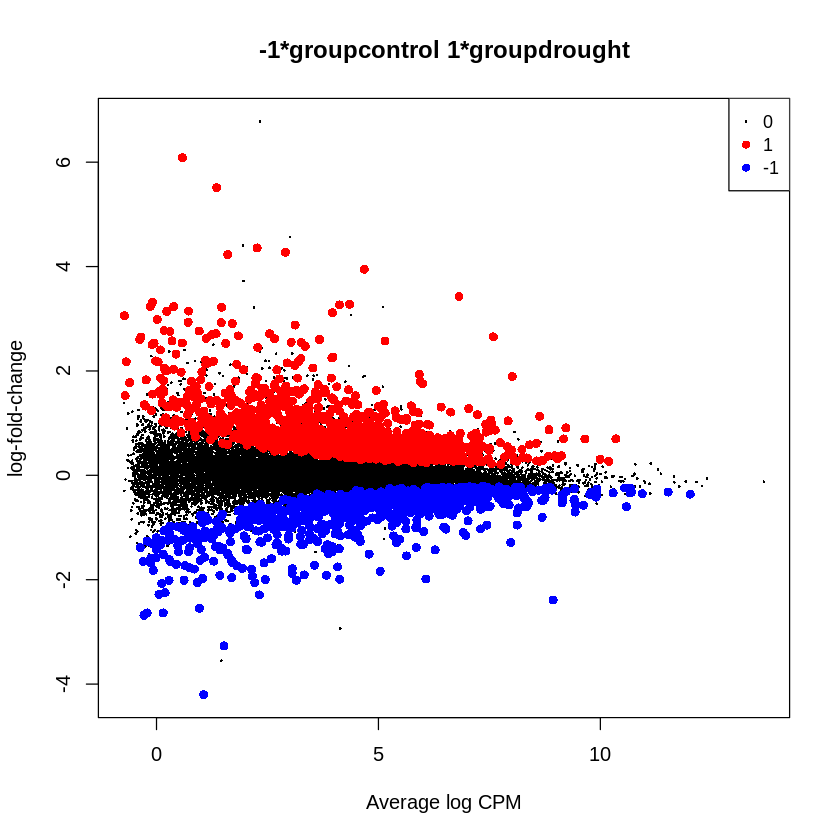

In [ ]:
plotMD(res, status=is.de, values=c(1,-1), col=c("red","blue"),
       legend="topright")

###Differential expression above a specified log-fold-change threshold


In [ ]:
#The easiest way to do this is to add further cutoffs to our subset function
subset(check$table, logFC < -1 & FDR < 0.05)
subset(check$table, logFC > 1 & FDR < 0.05)

,genes,logFC,logCPM,F,PValue,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GRMZM2G132547,GRMZM2G132547,-1.426913,6.27718800,197.99322,2.681751e-08,0.0002055652
GRMZM2G103647,GRMZM2G103647,-1.542851,5.63283239,163.52972,7.150050e-08,0.0002995648
GRMZM2G313184,GRMZM2G313184,-3.265420,1.52048520,160.69813,7.816093e-08,0.0002995648
GRMZM2G117956,GRMZM2G117956,-1.991566,4.12918710,139.57046,1.598281e-07,0.0004284876
GRMZM2G053720,GRMZM2G053720,-1.986537,6.06860009,166.64450,1.676982e-07,0.0004284876
AC210731.3_FG002,AC210731.3_FG002,-4.202697,1.06261764,118.24687,3.675692e-07,0.0006163600
GRMZM2G362848,GRMZM2G362848,-1.453493,2.81893965,104.30918,6.853632e-07,0.0008755896
GRMZM2G126900,GRMZM2G126900,-2.388383,8.93690063,148.72564,1.056910e-06,0.0010269006
GRMZM2G144224,GRMZM2G144224,-2.010049,3.14996992,92.90771,1.210820e-06,0.0010351762


,genes,logFC,logCPM,F,PValue,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GRMZM2G009282,GRMZM2G009282,1.214854,5.791065,308.98507,2.649623e-09,6.093072e-05
GRMZM2G064091,GRMZM2G064091,1.738208,3.638968,210.21840,1.968581e-08,2.055652e-04
AC186231.4_FG002,AC186231.4_FG002,2.056854,3.521778,174.18499,5.178536e-08,2.977140e-04
GRMZM2G002704,GRMZM2G002704,2.878226,3.124161,142.83034,1.557779e-07,4.284876e-04
GRMZM5G827496,GRMZM5G827496,1.162369,7.229086,134.38890,1.934443e-07,4.448445e-04
GRMZM2G169943,GRMZM2G169943,1.933443,5.921776,147.59490,3.124316e-07,6.163600e-04
GRMZM2G312069,GRMZM2G312069,1.695092,4.060916,119.12733,3.542006e-07,6.163600e-04
GRMZM2G007729,GRMZM2G007729,1.258609,5.092857,111.18345,4.995404e-07,7.658287e-04
GRMZM2G028325,GRMZM2G028325,1.319474,5.002718,107.01275,6.038660e-07,8.679064e-04


*Sidenote:*  
However, if one was to identify very high numbers of differentially expressed genes and wanted to apply more strict methods (in order to shorten the list to 
those that are biologically more relevant) there exists a better alternative to simply applying cutoffs.  
Namely, via the use of a more strict model than that used by glmQLFTest.  
This is due to glmQLFTest identifying differential expression based on statistical significance regardless of how small the difference might be.  
Using the glmTreat function one can directly perform tests which detect expression changes greater than a specified threshold.  

##Visualization of our final diff. exp. results

###1- Heat map clustering
Heatmaps are a very handy way to display differential expression results.  
First convert the read counts into log2-counts-per-million (lcpm) values, as we also did in the beginning of script.

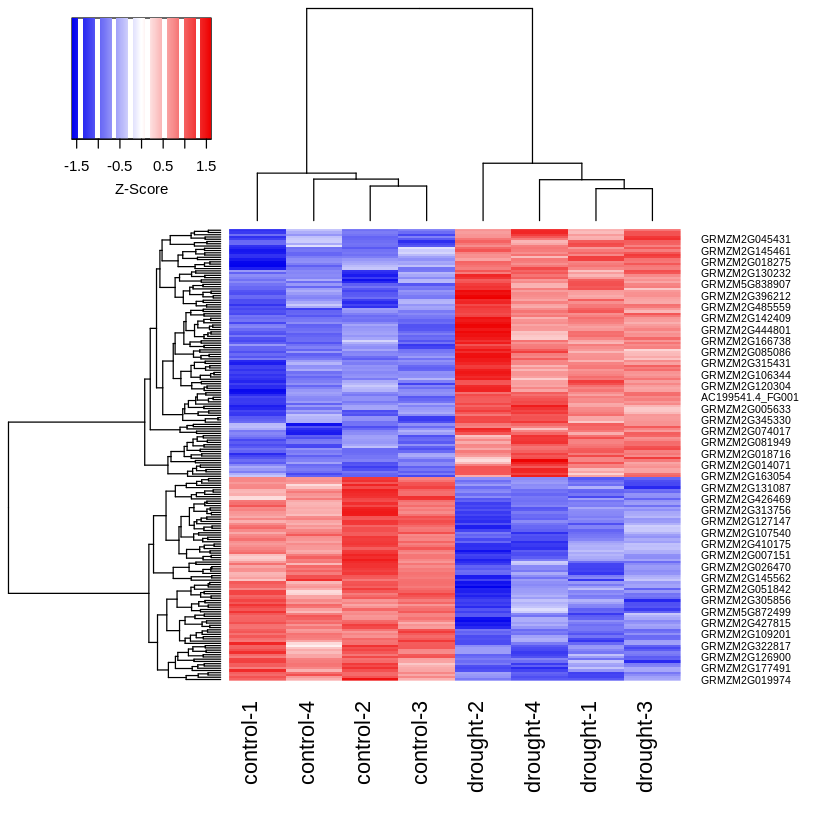

In [ ]:
#Running dev.off and repeating the code, helps when error messages appear; e.g. if creating heatmap of big size (gene number)
lcpm <- cpm(dge_normalized, log=TRUE, prior.count = 1)
colnames(lcpm) <- paste(dge_normalized$samples$group, 1:4, sep="-")

#Using a heatmap we can display the gene expression pattern across all the samples. 
#First we select the log2 CPM values for the 2000 top diff. exp. genes based on their p-values as computed in the diff. exp. test 
#(using all/too many genes may result in your R session crashing depending on the system you are running on):

o <- order(res$table$PValue)
lcpm <- lcpm[o[1:200],]

#lcpm <- lcpm[1:30,]

#We produce a heatmap via the coolmap function:
coolmap(lcpm, cluster.by = "de pattern", margins=c(8,8))

Coolmap is a great choice since the default clustering metrics are chosen to be appropriate for expression data.  
-> It will automatically standardize the expression values  

Some notes on interpretation of the colour coded Z-scores:  
Simply put, a Z-score represents the number of standard deviations from the mean value of the reference population/all samples.  
Z-scores thus inform you where the score lies on a normal distribution curve.  
Scores close to zero indicate that the values are exactly average while a score of e.g. +2 tells you that the value is much higher than average.  

Genes are clustered by correlation (highly correlated genes are closest).  
Samples are clustered, based on Euclidean distance between the expression values of the samples.  
Replicate samples from each group should thus be clustered together.

###2-Plotting the volcano
Volcano  plots allow for the visual summarization of  both fold-change and statistical significance (generally p-values).  
We will create a scatter-plot of the negative (log10 transformed) p-values of our diff. exp. test (y-axis) against the log2 fold change (x-axis).  

Even before plotting we can think about where the regions of interest in such a graph are:  
Points at the top of the plot possess small p-values thus being highly significant.  
Points being far away from the center (left or right) display the largest fold changes.

,logFC,negLogPval
,<dbl>,<dbl>
1,-0.15606663,1.18519832
2,0.37180003,1.62118850
3,0.05194684,0.05877113
4,0.03918832,0.07849665
5,0.53862424,0.77616131
6,-0.55137688,1.01870429


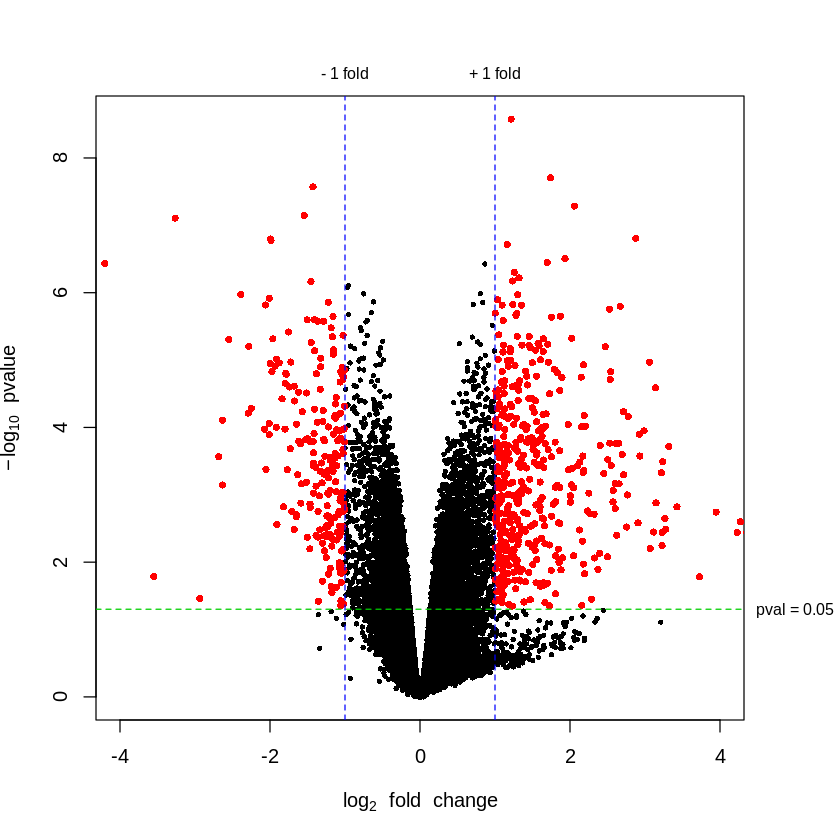

In [ ]:
## Let's start of by defining cutoffs for both the p-values and the log2 fold changes, e.g.:
lfc = 1
pval = 0.05

#We then create a smaller dataframe that contains our transformed p-values and the log2 fold changes of the respective genes:
tab = data.frame(logFC = res$table$logFC, negLogPval = -log10(res$table$PValue))
head(tab)

#next, we plot the basics
par(mar = c(5, 4, 4, 4))
plot(tab, pch = 16, cex = 0.6, 
     xlab = expression(log[2]~fold~change),ylab = expression(-log[10]~pvalue),
     xlim = c(-4,4))

#This already quite good and informative but we can still greatly improve it   
signGenes = (abs(res$table$logFC) > lfc & tab$negLogPval > -log10(pval))
points(tab[signGenes, ], pch = 16, cex = 0.8, col = "red")
abline(h = -log10(pval), col = "green3", lty = 2)
abline(v = c(-lfc, lfc), col = "blue", lty = 2)
mtext(paste("pval =", pval), side = 4, at = -log10(pval), cex = 0.8, line = 0.5, las = 1)
mtext(c(paste("-", lfc, "fold"), paste("+", lfc, "fold")), side = 3, at = c(-lfc, lfc),cex = 0.8, line = 0.5)

Red points indicate all genes having both fold-changes greater than our cutoff (x-axis) and high statistical significance (y-axis).  
The green line shows the p-value cutoff with points above the line having a p-value < 0.05 and points below the line having a p-value > 0.05.  
The vertical lines in blue colour show 1-fold changes.  

##Some final thoughts
Another important takeaway here is that even with base R and a bit of imagination extremely informative plots can be generated!  

To make all your future plots and graphs pretty, you can use the following link showcasing all colour option in base R :D 
http://www.stat.columbia.edu/~tzheng/files/Rcolor.pdf

## Exporting results for use in other analyses/software (e.g. MapMan)

For some follow-up analyses a transcript-level instead of a gene-level analysis & corresponding results might make more sense or are in fact necessary.  
Nevertheless, the following snippet is to demonstrate basic export of specific results for further downstream steps.  
  
The first thing to check is whether or not our data contains infinite fold changes.  
This shouldn't be the case because of the way edgeR works - however this is an important detail to keep in mind as software (e.g. MapMan) doesn't know what to do with them.  
In other pipelines it might be necessary to transform infinite values to a common number.  



In [ ]:
#Create an easy to view intermediate file - then inspect it (infinite fold changes?)
desired_subset <- topTags(res, adjust.method = "BH", n = "all")

#Create a subset containing only three columns: Gene ID, log2 fold change and q-value/FDR correction;
#while we're at it, let's keep the column names simple
desired_subset_B73 <- data.frame(desired_subset$table$genes, desired_subset$table$logFC, desired_subset$table$FDR)
colnames(desired_subset_B73) <- c("gene_id", "log2_fold_change", "q_value")

In [ ]:
#Write the data to a file - check and choose your working directory and file names - this file will be our input for MapMan
write.table(desired_subset_B73[,c("gene_id", "log2_fold_change", "q_value")], file="/desired_subset_B73.txt", sep="\t", col.names = T, row.names = F)

When using this script using colab, you can find your subset table under the root directory of the virtual machine.  
To navigate there use the left sidebar, click on files and move "up" (..) in the filesystem.  
Your .txt file should be at the bottom of the overview.  